In [1]:
%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import theano
import theano.tensor as T
import numpy as np
from schlichtanders.myoptimizers import online, batch
from schlichtanders.myfunctools import compose
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import time

In [3]:
from theano_models import shared, flatten_parameters, reparameterize_map, softplus, softplus_inv, total_size
from theano_models import reduce_all_identities, evaluate_all_unevaluated
import theano_models.probabilistic_models as pm
import theano_models.deterministic_models as dm

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


# Testing Gauss Distribution

For this test we simply try to approximate a diagonal gaussian distribution to given gaussian samples.

## model

In [4]:
size = 2
model = pm.DiagGauss(size)
model

{ 'RV': Elemwise{add,no_inplace}.0,
  'inputs': [],
  'logP': <function <lambda> at 0x7fe344fbfb90>,
  'outputs': Elemwise{add,no_inplace}.0,
  'parameters': [mean],
  'parameters_positive': [var]}

In [5]:
model.map('parameters_positive', reparameterize_map(softplus, softplus_inv), "parameters")
model

{ 'RV': Elemwise{add,no_inplace}.0,
  'inputs': [],
  'logP': <function <lambda> at 0x7fe344fbfb90>,
  'outputs': Elemwise{add,no_inplace}.0,
  'parameters': [mean, var_softplus],
  'parameters_positive': [var]}

## target

In [7]:
target = pm.DiagGauss(init_mean=[4,10], init_var=[0.5,2])

In [8]:
sampler = target.function()
sampler()

array([  3.57473607,  11.65060347])

In [9]:
n_samples = 400
targets = np.array([sampler() for _ in xrange(n_samples)])

## visualization

In [10]:
def plot_fit(fig, ax, time_delay=0.1):
    """ interactive plot of model fit
    
    Plots target data set as well as two Ellipse around target and model mean with width/height = 2* respective
    standard deviation.
    """
    ax.clear()
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    
    # plot data
    # ---------
    ax.plot(targets[:,0], targets[:,1], 'k.')
    
    # plot target
    # -----------
    target_mean = target.mean.eval()
    target_var = target.var.eval()
    
    # Ellipse
    e = Ellipse(target_mean, width=2*np.sqrt(target_var[0]), height=2*np.sqrt(target_var[1]))
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.1)
    e.set_facecolor([1, 0.1, 0.1])
    ax.add_patch(e)

    # plot model
    # -----------
    model_mean = model.mean.eval()
    model_var = model.var.eval()
    # text
    ax.text(0.1, 0.2, 'm=%g,%g' % tuple(model_mean),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes)
    ax.text(0.1, 0.1, 'v=%g,%g' % tuple(model_var),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes)
    # Ellipse
    e = Ellipse(model_mean, width=2*np.sqrt(model_var[0]), height=2*np.sqrt(model_var[1]))
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.2)
    e.set_facecolor([0.1, 0.2, 0.4])
    ax.add_patch(e)
    # Point  # we need to add a normal plot, as then the axis adjust automatically
    ax.plot(model_mean[0], model_mean[1], '+', color=[0.1, 0.2, 0.4], markersize=10)
    
    # interactively redraw
    # --------------------
    fig.canvas.draw()
    time.sleep(time_delay) # just because the fit is to fast otherwise

<IPython.core.display.Javascript object>


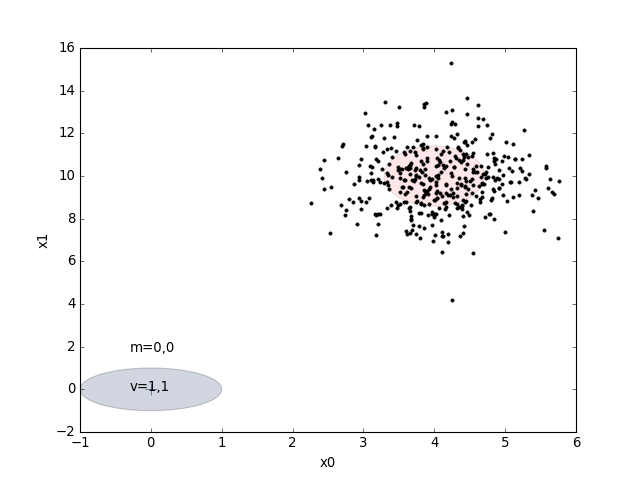

In [11]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [ ]:
myoptimizer = opt.ScipyOptimizer(batch)
# CAUTION: scipy args needs to be tuple in order to work as expected!
myoptimizer.optimize(
    model, args=(targets,),
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda x: plot_fit(fig, ax)
)

In [ ]:
print model.var_from_Var(model._Var.get_value(), module=np)
print model.mean.get_value()

## Evaluation - TODO

sometimes the above optimizer first overshoots the variance along x1 extremely (if the initial means are farer away, it is even worse).
The resulting errors are either precision loss, or var[1] = inf. (tested on default optimizer BFGS)


If I try the algorithms online, they almost immediately stop with precision loss ('Nelder-Mead' method does something, however needs extremely long and the variances are also not well approximated).

# Uniform Distribution

## model

In [ ]:
model = pm.Uniform(size=2)
m_sampler = model.function()

## target

In [ ]:
target = pm.Uniform(init_start=[1,4], init_offset=[2,1])
t_sampler = target.function()
t_sampler()

In [ ]:
n_samples = 400
targets = np.array([t_sampler() for _ in xrange(n_samples)])

In [ ]:
targets[:10]

## visualize

In [ ]:
def plot_fit(fig, ax, time_delay=0.1):
    ax.clear()
    
    # targets
    ax.plot(targets[:,0], targets[:,1], "k.")
    
    # model
    model_samples = np.array([m_sampler() for _ in xrange(n_samples)])
    ax.plot(model_samples[:,0], model_samples[:,1], "r.")
    fig.canvas.draw()
    time.sleep(time_delay)

In [ ]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [ ]:
myoptimizer = opt.ScipyOptimizer(batch)
# CAUTION: scipy args needs to be tuple in order to work as expected!
myoptimizer.optimize(
    model, args=(targets,),
#     method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda x: plot_fit(fig, ax)
)

TODO this does not work. Check whether the gradient is the reason (there is no gradient of the step probability function).

# test scipy minimize

Just to be sure that everything is as thought

In [ ]:
from scipy.optimize import minimize

In [ ]:
def mse(a, *args, **kwargs):
    aim = kwargs.pop('aim', np.array([42,3]))
    print args
    return np.sum((a - aim)**2)

In [ ]:
minimize(fun=mse, x0=np.array([1,-4]), args=[1,2], options={'maxiter': 10, 'disp': True})

works